# Running stable-diffusion-x4-upscaler with SageMaker transform job

本ノートブックでは，SageMaker Jumpstartが提供するstable diffusion x4 upscaler modelを利用し，Transform jobで推論実行が可能であることを検証する．

### Set Up

In [3]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Permissions

In [4]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

sess = sagemaker.Session()
bucket = sess.default_bucket()
aws_role = get_execution_role()

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Retrieve Artifacts & Deploy an Endpoint

***

Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.

***

In [5]:
model_id, model_version = "model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16", "*"

In [6]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters, instance_types
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

# Instances with more GPU memory supports generation of larger images.
# So, please select instance types such as ml.g5.2xlarge if you want to generate a very large image.
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=model_id,
    model_version=model_version,
    scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

In [7]:
print(f"endpoint_name: {endpoint_name}")
print(f"inference_instance_type: {inference_instance_type}")
print(f"deploy_image_uri: {deploy_image_uri}")
print(f"model_uri: {model_uri}")
print(f"model: {model}")

endpoint_name: jumpstart-example-model-upscaling-stabi-2023-09-01-05-48-06-346
inference_instance_type: ml.p3.2xlarge
deploy_image_uri: 763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
model_uri: s3://jumpstart-cache-prod-ap-northeast-1/stabilityai-infer/prepack/v1.0.0/infer-prepack-model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16.tar.gz
model: <sagemaker.model.Model object at 0x7fdfcf52f490>


### Run Transform job

---
Input to the Transform job is a prompt, a low resolution image and image generation parameters in json format and encoded in `utf-8` format. Output of the endpoint is a `json` with generated images and the input prompt.

---

#### Download example low resolution image
---
We start by downloading an example image with low resolution.

---

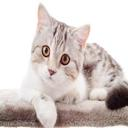

In [8]:
from IPython.display import Image

region = boto3.Session().region_name
s3_bucket = f"jumpstart-cache-prod-{region}"
key_prefix = "stabilityai-metadata/assets"
low_res_img_file_name = "low_res_cat.jpg"
s3 = boto3.client("s3")

s3.download_file(s3_bucket, f"{key_prefix}/{low_res_img_file_name}", low_res_img_file_name)

# Displaying the original image
Image(filename=low_res_img_file_name, width=632, height=632)

#### Prepare the dataset locally and upload it to S3

In [9]:
import os
import base64

data_bucket = bucket
data_prefix = "sagemaker/input/transformer-job/sd-upscale"
output_prefix = "sagemaker/output/transformer-job/sd-upscale"
data_file_name = "low-res-cat.json"

data_file_name1 = "low-res-cat1.json"
data_file_name2 = "low-res-cat2.json"
low_res_img_file_name = "low_res_cat.jpg"

with open(low_res_img_file_name, "rb") as f:
    low_res_images_bytes = f.read()
    encoded_image = base64.b64encode(bytearray(low_res_images_bytes)).decode()
    
payload = {
    "prompt": "a cat",
    "image": encoded_image,
    "num_inference_steps": 50,
    "guidance_scale": 7.5
}

# create default json file
with open(data_file_name, "w") as outfile:
    outfile.write("%s\n" % json.dumps(payload))
    

# Uploading the data
s3 = boto3.client("s3")
for target_name in [data_file_name1, data_file_name2]:
    data_path = os.path.join(data_prefix, target_name)
    s3.upload_file(data_file_name, data_bucket, data_path) # upload two same low-res-cat.json files as low-res-cat1.json and low-res-cat2.json

#### Create Transform job

In [11]:
batch_transformer = model.transformer(
    instance_count=1,
    instance_type=inference_instance_type,
    output_path=f"s3://{data_bucket}/{output_prefix}",
    accept="application/json;jpeg",
    max_payload=10,
)

s3_input_data_path = f"s3://{data_bucket}/{data_prefix}"

batch_transformer.transform(
    s3_input_data_path,
    content_type="application/json;jpeg",
    split_type="Line"
)
batch_transformer.wait()

INFO:sagemaker:Creating transform job with name: jumpstart-example-model-upscaling-stabi-2023-09-01-06-02-09-965


..............................................Processing /opt/ml/model/code/lib/accelerate/accelerate-0.14.0-py3-none-any.whl
Processing /opt/ml/model/code/lib/diffusers/diffusers-0.9.0-py3-none-any.whl
Processing /opt/ml/model/code/lib/scipy/scipy-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /opt/ml/model/code/lib/transformers/transformers-4.24.0-py3-none-any.whl
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.17.0
    Uninstalling transformers-4.17.0:
      Successfully uninstalled transformers-4.17.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.17.0
    Uninstalling transformers-4.17.0:
      Successfully uninstalled transformers-4.17.0
[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --u

### Download and Display result

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from io import BytesIO

def list_files_in_s3_directory(bucket_name, directory_prefix):
    """
    List all files in a specific S3 bucket directory.
    
    Parameters:
        bucket_name (str): The name of the S3 bucket.
        directory_prefix (str): The directory within the S3 bucket.
        
    Returns:
        list: A list of file names within the specified directory.
    """
    # s3_client = boto3.client('s3')
    file_list = []
    
    # List objects within the specified directory
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=directory_prefix)
    
    # Check if the directory is empty or doesn't exist
    if 'Contents' not in response:
        return []
    
    # Extract file names from the response
    for item in response['Contents']:
        file_name = item['Key']
        file_list.append(file_name)
        
    return file_list


def delete_extension_to_get_json_file(filename):
    return os.path.splitext(filename)[0]


def download_result(bucket, results):
    result_dir = "result"
    os.makedirs(result_dir, exist_ok=True)
    for result in results:
        save_file_name = delete_extension_to_get_json_file(result)
        print(save_file_name)
        s3.download_file(bucket, result, f"{result_dir}/{os.path.basename(save_file_name)}")

        
def decode2jpeg(image_encoded: str):
    decoded_image = BytesIO(base64.b64decode(image_encoded.encode()))
    decoded_image_rgb = Image.open(decoded_image).convert("RGB")
    return decoded_image_rgb


def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

sagemaker/output/transformer-job/sd-upscale/low-res-cat1.json
sagemaker/output/transformer-job/sd-upscale/low-res-cat2.json


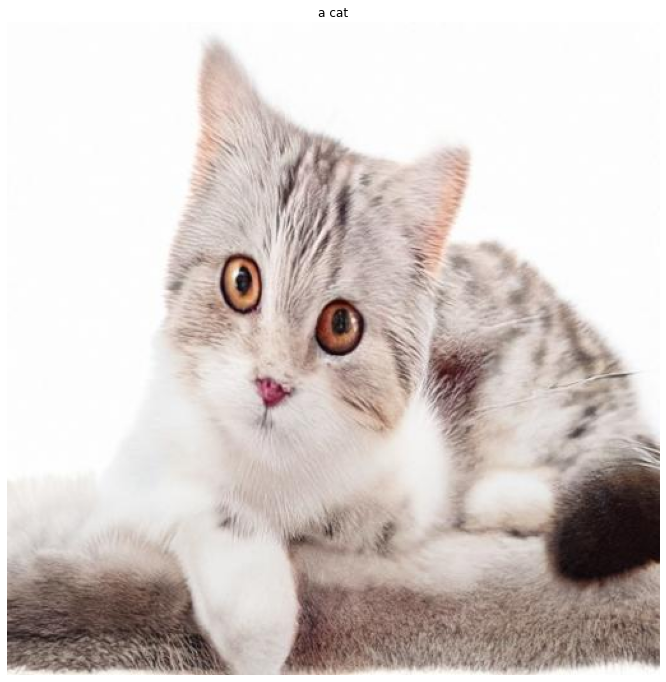

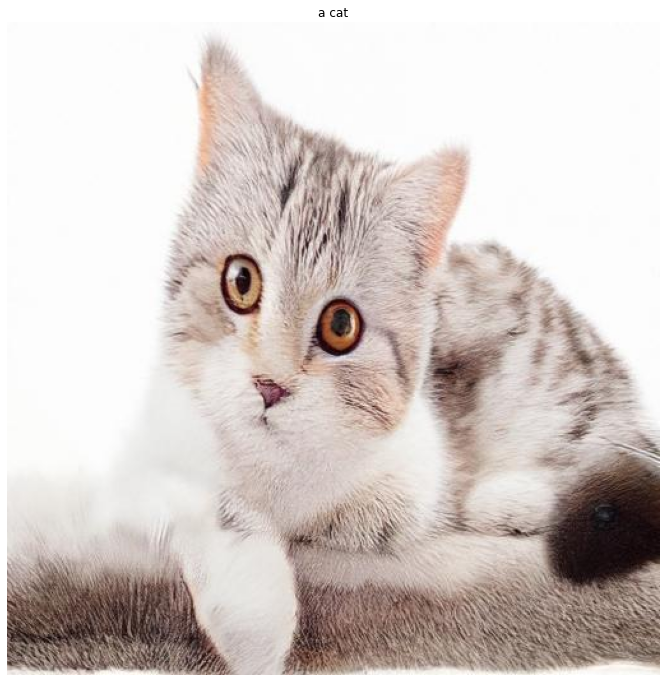

In [52]:
results = list_files_in_s3_directory(data_bucket, output_prefix)
download_result(data_bucket, results)

for result in results:
    result = f"result/{os.path.basename(delete_extension_to_get_json_file(result))}"
    with open(result) as f:
        response = json.load(f)
    generated_image = response["generated_images"][0]
    prompt = response["prompt"]
    decoded_image = decode2jpeg(generated_image)
    # You can save the generated image by calling decoded_image.save('upscaled_cat_image.jpg')
    display_img_and_prompt(decoded_image, prompt)

# References

- [SageMaker JumpStart Foundation Models - HuggingFace Text2Text Generation Batch Transform and Real-Time Batch Inference](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/jumpstart-foundation-models/text2text-generation-Batch-Transform.html)